In [1]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib import gridspec
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
import sys
sys.path.append(os.path.join(Path(os.getcwd()).parents[0], "functions"))
import warnings
warnings.filterwarnings('ignore')
import helper_functions as hfn
import AIC_functions as aicfn
import plotting_functions as plotfn

In [2]:
# load models from lmfit package
from lmfit import Model
from lmfit.models import PowerLawModel
from lmfit.models import LognormalModel
from lmfit.models import ExponentialModel
from lmfit.models import LinearModel
from lmfit.models import QuadraticModel

In [3]:
def growth(x, i_max, ks):
    # x = starter number
    # we fit y = input number
    return i_max * x / (ks + x)

def hill(x, i_max, ks,n):
    return i_max / (1 + (ks/x)**n)

In [4]:
class ScalarFormatterForceFormat(ScalarFormatter):
    def _set_format(self):  # Override function that finds format to use.
        self.format = "%1.1f"  # Give format here

In [5]:
# create lmfit models for fits
model_pl = PowerLawModel()
model_exp = Model(aicfn.expfunc)#ExponentialModel(prefix = 'exp')
model_ln = LognormalModel()
model_lm = LinearModel()
model_quad = QuadraticModel()
gmodel = Model(growth)
hmodel = Model(hill)

In [6]:
path = Path(os.getcwd()).parents[0]
ectpath = os.path.join(path, 'data/external_data')

In [7]:
figpath = os.path.join(path, 'figures')
hfn.dir_check(figpath)

figs11path = os.path.join(figpath, 'FigS1')
hfn.dir_check(figs11path)

figs11panelpaths = os.path.join(figs11path, 'panels')
hfn.dir_check(figs11panelpaths)

# set plotting params

In [8]:
colors = ["windows blue", "amber", "greyish", "faded green", "dusty purple", 'coral']
sns.set_palette = sns.xkcd_palette(colors)
sns.set_style("ticks")
hfont = {'fontname':'Myriad Pro'}

In [9]:
def fit_all_models(data, parsexp, parsln):
    ## linear fit
    pars_lm = model_lm.guess(data['input'].values, x = data['starter'].values)
    res_lm = model_lm.fit(data['input'].values, pars_lm, x = data['starter'].values)

    ## quadratic fit
    pars_quad = model_quad.guess(data['input'].values, x = data['starter'].values)
    res_quad = model_quad.fit(data['input'].values, pars_quad, x = data['starter'].values)

    ## power-law fit
    pars_pl = model_pl.guess(data['input'].values, x = data['starter'].values)
    res_pl = model_pl.fit(data['input'].values, pars_pl, x = data['starter'].values)

    ## exponential fit
    pars_exp = model_exp.make_params(a = parsexp[0], b = parsexp[1])
    res_exp = model_exp.fit(data['input'].values, pars_exp, x = data['starter'].values)

    ## log-normal fit
    pars_ln = model_ln.guess(data['input'].values, x = data['starter'].values)
    pars_ln['amplitude'].set(parsln[0], vary = True)
    pars_ln['sigma'].set(parsln[1], vary = True)
    pars_ln['center'].set(parsln[2], vary = True)
    res_ln = model_ln.fit(data['input'].values, pars_ln, x = data['starter'].values)
    
    ## Growth model fit
    datax = data['starter'].values
    pars_g = gmodel.make_params(i_max = np.max(data['input'].values), ks =  datax[hfn.find_nearest(data['input'].values, np.max(data['input'].values)/2)[0]])
    res_growth = gmodel.fit(data['input'].values, pars_g, x = data['starter'].values)   
    
    ## Hill model fit
    parsh = hmodel.make_params(i_max = np.max(data['input'].values), ks = datax[hfn.find_nearest(data['input'].values, np.max(data['input'].values)/2)[0]], n = 0.5)
    parsh['ks'].set(min=0.0001)
    parsh['i_max'].set(min=np.min(data['input'].values))
    res_hill = hmodel.fit(data['input'].values, parsh, x = data['starter'].values)    
    
    
    return res_lm , res_quad, res_pl, res_exp, res_ln, res_growth, res_hill

In [10]:
def fit_log_models(datalog):
    ## linear fit
    pars_log_lm = model_lm.guess(datalog['input'].values, x = datalog['starter'].values)
    res_log_lm = model_lm.fit(datalog['input'].values, pars_log_lm, x = datalog['starter'].values)

    ## quadratic fit
    pars_log_quad = model_quad.guess(datalog['input'].values, x = datalog['starter'].values)
    res_log_quad = model_quad.fit(datalog['input'].values, pars_log_quad, x = datalog['starter'].values)
    return res_log_lm, res_log_quad

In [11]:
def plot_panel_a(data_df, list_results, ymax):
    list_fits_ln = list_results
    fit_type = ['linear', 'quadratic', 'power-law', 'exponential', 'growth', 'hill'] # 'log-normal'

    f1a = plt.figure(figsize = (3.5,3.5), constrained_layout = True)

    ax = f1a.add_subplot(111)
    ax.tick_params(labelsize = 16)

    plt.scatter(data_df['starter'].values, data_df['input'].values, label ='data', color = 'k', alpha = 0.6, s = 80, edgecolors='none')

    for i, fit in enumerate(list_fits_ln):
        plt.plot(data_df['starter'].values, fit, color=sns.xkcd_palette(colors)[i], label = fit_type[i])
    ax.ticklabel_format(style='sci', scilimits=(0,0), axis='y')

    plt.locator_params(axis='x', nbins=3)
    plt.ylim((0, ymax))
    plt.xlabel('starters',fontsize = 16)
    plt.ylabel('inputs',fontsize = 16)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False) 
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(14)

In [12]:
def plot_panel_b(result):
    f1b = plt.figure(figsize = (3.5, 2.8), constrained_layout=True)
    ax = plt.gca()

    plt.scatter(result.best_fit, result.residual/np.std(result.residual), facecolors = 'none', s= 80, edgecolors='k')
    x1, x2 = ax.get_xlim()
    plt.axhline(y = 0, xmin = 0, xmax = x2, ls = '--', c = 'k')
    max_ax = max(np.abs(ax.get_ylim()))
    plt.ylim((-max_ax, max_ax))
    plt.locator_params(axis='x', nbins = 3)
    plt.ylabel('standardized residuals', fontsize = 16)
    plt.xlabel('fitted values', fontsize = 16)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(14)

In [13]:
def plot_panel_c(data_log_df, list_results, ymin, ymax):
    list_fits_ln = list_results
    fit_type = ['linear', 'quadratic']

    f1c = plt.figure(figsize = (3.5,3.5), constrained_layout = True)

    ax = f1c.add_subplot(111)
    ax.tick_params(labelsize=16)

    plt.scatter(data_log_df['starter'].values, data_log_df['input'].values, label='data', color = 'k', alpha = 0.6, s= 80, edgecolors='none')

    for i, fit in enumerate(list_fits_ln):
        plt.plot(data_log_df['starter'].values, fit, color=sns.xkcd_palette(colors)[i], label = fit_type[i])


    plt.locator_params(axis = 'x', nbins = 3)
    plt.ylim((ymin, ymax))
    plt.xlabel(r'$\mathrm{Log}_{10}(starters)$',fontsize = 16)
    plt.ylabel(r'$\mathrm{Log}_{10}(inputs)$',fontsize = 16)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(14) 

In [14]:
def plot_fig(data_df, list_results, ymax, result, data_log_df, list_results_log, ymin_log, ymax_log, result_log):
    f1 = plt.figure(figsize= (5.8, 6))
    gs = f1.add_gridspec(5, 7)

    # panel A
    ax_1a = f1.add_subplot(gs[:3, :-4])

    ax_1a.tick_params(labelsize=12)
    ax_1a.scatter(data_df['starter'].values,data_df['input'].values, label='data', color = 'k', alpha = 0.6, s= 80, edgecolors='none')
    list_fits_ln = list_results
    fit_type = ['linear', 'quadratic', 'power-law', 'exponential', 'growth'] # 'log-normal'

    for i, fit in enumerate(list_fits_ln):
        plt.plot(data_df['starter'].values, fit, color=sns.xkcd_palette(colors)[i], label = fit_type[i])

#     ax_1a.ticklabel_format(style='sci', scilimits=(0,0), axis='y')
    plt.locator_params(axis='x', nbins=4)
    ax_1a.set_ylim((0,ymax))
    ax_1a.set_xlabel('starters',fontsize = 16)
    ax_1a.set_ylabel('inputs',fontsize = 16)

    ax_1a.spines['right'].set_visible(False)
    ax_1a.spines['top'].set_visible(False)
    ax = plt.gca()
    yfmt = ScalarFormatterForceFormat()
    yfmt.set_powerlimits((0,0))
    plt.gca().yaxis.set_major_formatter(yfmt)
    plt.locator_params(axis='x', nbins=2)
    # panel B

    ax_1b = f1.add_subplot(gs[:3, -3:])

    ax_1b.tick_params(labelsize=12)
    ax_1b.scatter(data_log_df['starter'].values,data_log_df['input'].values, label='data', color = 'k', alpha = 0.6, s= 80, edgecolors='none')
    list_fits_log = list_results_log
    fit_type_log = ['linear', 'quadratic']
    for i, fit in enumerate(list_fits_log):
        plt.plot(data_log_df['starter'].values, fit, color=sns.xkcd_palette(colors)[i], label = fit_type_log[i])
#     plt.legend(fontsize=12, loc='lower left', bbox_to_anchor=(0.7, 0.05))
    ax_1b.set_xlabel(r'$\mathrm{Log}_{10}(starters)$',fontsize = 16)
    ax_1b.set_ylabel( r'$\mathrm{Log}_{10}(inputs)$', fontsize = 16)
    ax_1b.set_ylim((ymin_log, ymax_log))
    ax_1b.spines['right'].set_visible(False)
    ax_1b.spines['top'].set_visible(False)
    plt.locator_params(axis='x', nbins=2)
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.1f'))


    # panel C
    ax_1c1 = f1.add_subplot(gs[4:, :-4])
    ax_1c1.scatter(result.best_fit, result.residual/np.std(result.residual), facecolors = 'none', s= 80, edgecolors='k')
    ax_1c1.set_ylabel('standardized res.',fontsize = 16)
    ax_1c1.set_xlabel('fitted values',fontsize = 16)

    x1, x2 = ax_1c1.get_xlim()
    max_ax1 = max(np.abs(ax_1c1.get_ylim()))
    ax_1c1.set_ylim((-max_ax1-0.2, max_ax1+0.2))
    ax_1c1.axhline(y=0, xmin=0, xmax=x2,c='k', ls='--')
    ax_1c1.spines['right'].set_visible(False)
    ax_1c1.spines['top'].set_visible(False)
    plt.ylim(-2.8, 2.8)
    plt.locator_params(axis='x', nbins=2)
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

    ax_1c2 = f1.add_subplot(gs[4:, -3:])

    ax_1c2.scatter(result_log.best_fit, result_log.residual/np.std(result_log.residual), facecolors = 'none', s= 80, edgecolors='k')
    ax_1c2.set_ylabel('standardized res.',fontsize = 16)
    ax_1c2.set_xlabel('fitted values',fontsize = 16)
    x1, x2 = ax_1c2.get_xlim()
    max_ax2 = max(np.abs(ax_1c2.get_ylim()))
    ax_1c2.set_ylim((-max_ax2-0.2, max_ax2+0.2))
    ax_1c2.axhline(y=0, xmin=0, xmax=x2,c='k', ls='--')
    ax_1c2.spines['right'].set_visible(False)
    ax_1c2.spines['top'].set_visible(False)
    plt.ylim(-2.8, 2.8)
    plt.locator_params(axis='x', nbins=2)
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    
    for label in (ax_1a.get_xticklabels() + ax_1a.get_yticklabels() + ax_1b.get_xticklabels() + ax_1b.get_yticklabels() + ax_1c1.get_xticklabels() + ax_1c1.get_yticklabels() + ax_1c2.get_xticklabels() + ax_1c2.get_yticklabels()):
        label.set_fontsize(14)
                           
    
    ax_1a.set_rasterized(True)
    ax_1b.set_rasterized(True)
    ax_1c1.set_rasterized(True)
    ax_1c2.set_rasterized(True)
    plt.gcf().set_size_inches(5.8, 6)

# Load data

## 1. Beier data

In [15]:
pathdata1 = os.path.join(ectpath, 'data_Beier')
figpath1 = os.path.join(figs11panelpaths, 'data_Beier')
hfn.dir_check(figpath1)

In [16]:
df_raw1 = aicfn.import_data(pathdata1).dropna()
# log10 transformed datasets
df_log1 = hfn.make_log_df(df_raw1)

In [17]:
result_lm1, result_quad1, result_pl1, result_exp1, result_ln1, result_growth1, result_hill1 = fit_all_models(df_raw1, [1000, -500], [6000, 5, 18])

In [18]:
result_log_lm1, result_log_quad1 = fit_log_models(df_log1)

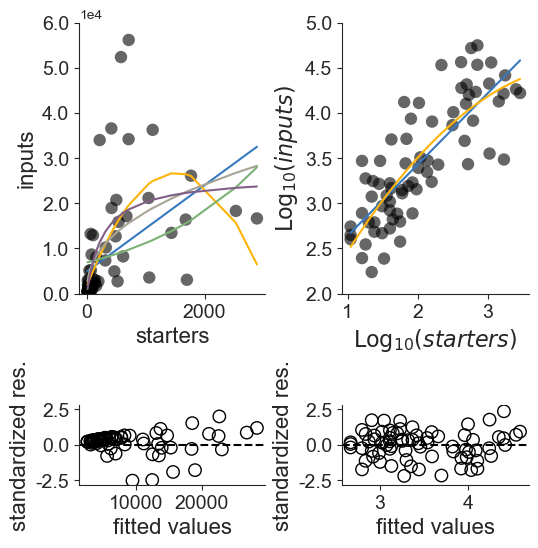

In [19]:
plot_fig(df_raw1, [result_lm1.best_fit, result_quad1.best_fit, result_pl1.best_fit, result_exp1.best_fit, result_growth1.best_fit], 6*10**4, result_pl1, df_log1, [result_log_lm1.best_fit, result_log_quad1.best_fit], 2, 5,result_log_lm1)
plt.savefig(os.path.join(figpath1, 'fig_s1_1.png'),  bbox_inches='tight')
plt.savefig(os.path.join(figpath1, 'fig_s1_1.eps'),  bbox_inches='tight', format = 'eps', dpi= 300)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


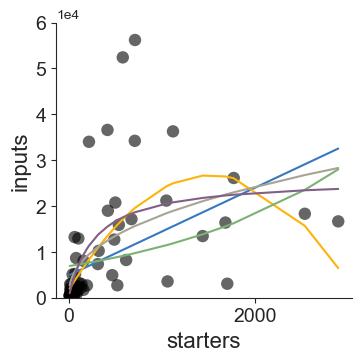

In [20]:
# Panel A1 : fit data in natural scale
plot_panel_a(df_raw1, [result_lm1.best_fit, result_quad1.best_fit, result_pl1.best_fit, result_exp1.best_fit, result_growth1.best_fit], 6*10**4)

plt.savefig(os.path.join(figpath1, 'fig_s1_1a1.png'),  bbox_inches='tight')
plt.savefig(os.path.join(figpath1, 'fig_s1_1a1.eps'),  bbox_inches='tight', format = 'eps', dpi= 300)

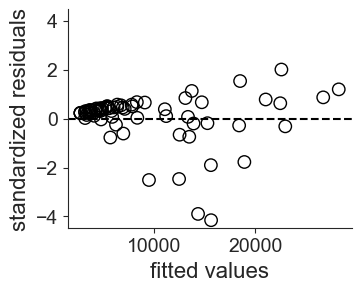

In [21]:
# Panel B1
plot_panel_b(result_pl1)
plt.savefig(os.path.join(figpath1, 'fig_s1_1b1.png'),  bbox_inches='tight')
plt.savefig(os.path.join(figpath1, 'fig_s1_1b1.eps'),  bbox_inches='tight', format = 'eps', dpi= 300)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


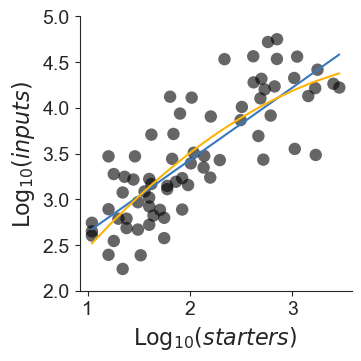

In [22]:
# Panel C1 : fit data in natural scale
plot_panel_c(df_log1, [result_log_lm1.best_fit, result_log_quad1.best_fit], 2, 5)
plt.savefig(os.path.join(figpath1, 'fig_s1_1c1.png'),  bbox_inches='tight')
plt.savefig(os.path.join(figpath1, 'fig_s1_1c1.eps'),  bbox_inches='tight', format = 'eps', dpi= 300)

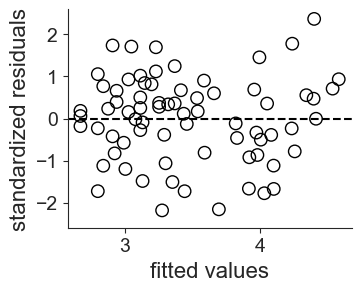

In [23]:
plot_panel_b(result_log_lm1)
plt.savefig(os.path.join(figpath1, 'fig_s1_1d1.png'),  bbox_inches='tight')
plt.savefig(os.path.join(figpath1, 'fig_s1_1d1.eps'),  bbox_inches='tight', format = 'eps', dpi= 300)

## 2. Vinograd data

In [24]:
pathdata2 = os.path.join(ectpath, 'data_Vinograd')
figpath2 = os.path.join(figs11panelpaths, 'data_Vinograd')
hfn.dir_check(figpath2)

In [25]:
df_raw2 = aicfn.import_data(pathdata2)
# log10 transformed datasets
df_log2 = hfn.make_log_df(df_raw2)

In [26]:
result_lm2, result_quad2, result_pl2, result_exp2, result_ln2, result_growth2, result_hill2 = fit_all_models(df_raw2, [1000, -500], [6000, 5, 18])

In [27]:
result_log_lm2, result_log_quad2 = fit_log_models(df_log2)

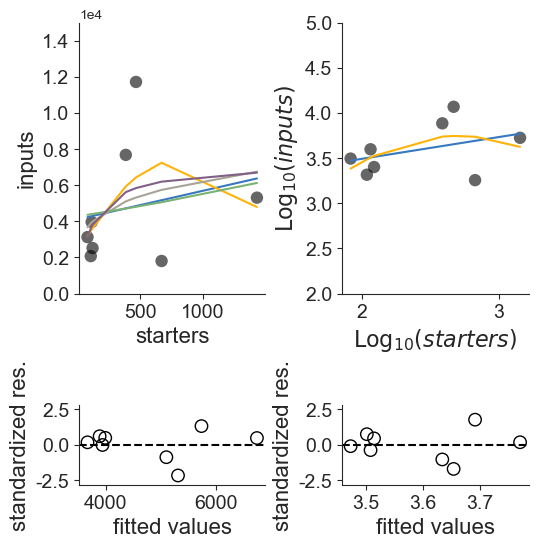

In [28]:
plot_fig(df_raw2, [result_lm2.best_fit, result_quad2.best_fit, result_pl2.best_fit, result_exp2.best_fit, result_growth2.best_fit], 1.5*10**4, result_pl2, df_log2, [result_log_lm2.best_fit, result_log_quad2.best_fit], 2, 5,result_log_lm2)
plt.savefig(os.path.join(figpath2, 'fig_s1_1.png'),  bbox_inches='tight')
plt.savefig(os.path.join(figpath2, 'fig_s1_1.eps'),  bbox_inches='tight', format = 'eps', dpi= 300)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


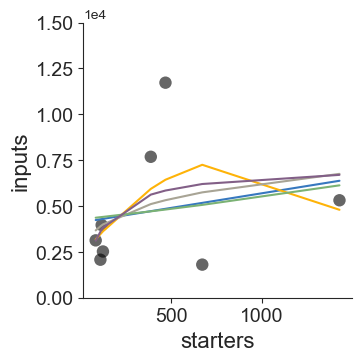

In [29]:
# Panel A1 : fit data in natural scale
plot_panel_a(df_raw2, [result_lm2.best_fit, result_quad2.best_fit, result_pl2.best_fit, result_exp2.best_fit, result_growth2.best_fit], 1.5*10**4)

plt.savefig(os.path.join(figpath2, 'fig_s1_1a2.png'),  bbox_inches='tight')
plt.savefig(os.path.join(figpath2, 'fig_s1_1a2.eps'),  bbox_inches='tight', format = 'eps', dpi= 300)

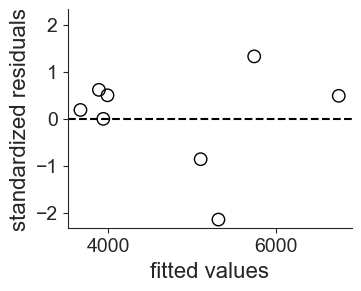

In [30]:
# Panel B1
plot_panel_b(result_pl2)
plt.savefig(os.path.join(figpath2, 'fig_s1_1b2.png'),  bbox_inches='tight')
plt.savefig(os.path.join(figpath2, 'fig_s1_1b2.eps'),  bbox_inches='tight', format = 'eps', dpi= 300)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


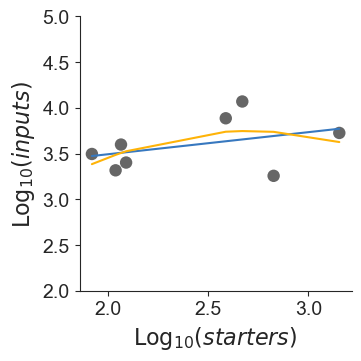

In [31]:
# Panel C1 : fit data in natural scale
plot_panel_c(df_log2, [result_log_lm2.best_fit, result_log_quad2.best_fit], 2, 5)
plt.savefig(os.path.join(figpath2, 'fig_s1_1c2.png'),  bbox_inches='tight')
plt.savefig(os.path.join(figpath2, 'fig_s1_1c2.eps'),  bbox_inches='tight', format = 'eps', dpi= 300)

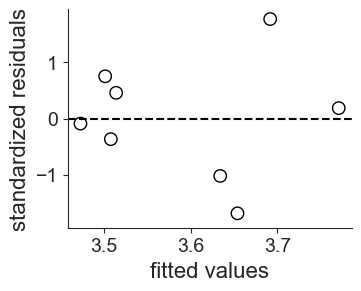

In [32]:
plot_panel_b(result_log_lm2)
plt.savefig(os.path.join(figpath2, 'fig_s1_1d2.png'),  bbox_inches='tight')
plt.savefig(os.path.join(figpath2, 'fig_s1_1d2.eps'),  bbox_inches='tight', format = 'eps', dpi= 300)

## 3. Brown data

In [33]:
pathdata3 = os.path.join(ectpath, 'data_Brown')
figpath3 = os.path.join(figs11panelpaths, 'data_Brown')
hfn.dir_check(figpath3)

In [34]:
df_raw3 = aicfn.import_data(pathdata3)
# log10 transformed datasets
df_log3 = hfn.make_log_df(df_raw3)

In [35]:
result_lm3, result_quad3, result_pl3, result_exp3, result_ln3, result_growth3, result_hill3 = fit_all_models(df_raw3, [1000, 500], [6000, 5, 18])

In [36]:
result_log_lm3, result_log_quad3 = fit_log_models(df_log3)

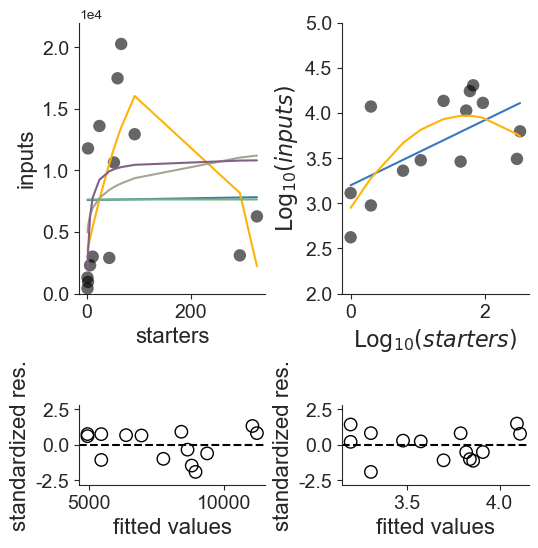

In [37]:
plot_fig(df_raw3, [result_lm3.best_fit, result_quad3.best_fit, result_pl3.best_fit, result_exp3.best_fit, result_growth3.best_fit], 2.2*10**4, result_pl3, df_log3, [result_log_lm3.best_fit, result_log_quad3.best_fit], 2, 5,result_log_lm3)
plt.savefig(os.path.join(figpath3, 'fig_s1_1.png'),  bbox_inches='tight')
plt.savefig(os.path.join(figpath3, 'fig_s1_1.eps'),  bbox_inches='tight', format = 'eps', dpi= 300)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


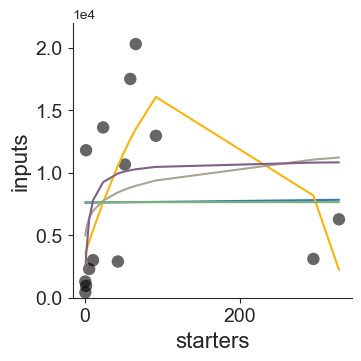

In [38]:
# Panel A1 : fit data in natural scale
plot_panel_a(df_raw3, [result_lm3.best_fit, result_quad3.best_fit, result_pl3.best_fit, result_exp3.best_fit, result_growth3.best_fit], 2.2*10**4)

plt.savefig(os.path.join(figpath3, 'fig_s1_1a3.png'),  bbox_inches='tight')
plt.savefig(os.path.join(figpath3, 'fig_s1_1a3.eps'),  bbox_inches='tight', format = 'eps', dpi= 300)

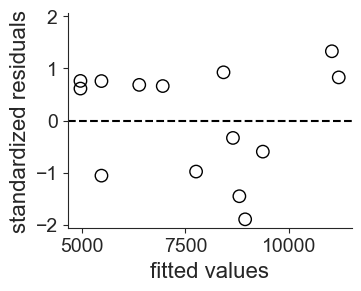

In [39]:
# Panel B1
plot_panel_b(result_pl3)
plt.savefig(os.path.join(figpath3, 'fig_s1_1b3.png'),  bbox_inches='tight')
plt.savefig(os.path.join(figpath3, 'fig_s1_1b3.eps'),  bbox_inches='tight', format = 'eps', dpi= 300)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


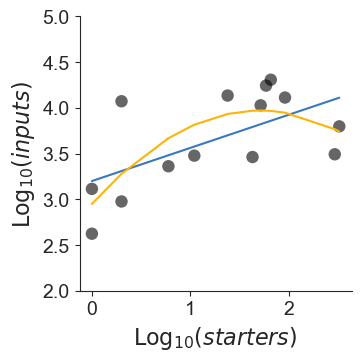

In [40]:
# Panel C1 : fit data in natural scale
plot_panel_c(df_log3, [result_log_lm3.best_fit, result_log_quad3.best_fit], 2, 5)
plt.savefig(os.path.join(figpath3, 'fig_s1_1c3.png'),  bbox_inches='tight')
plt.savefig(os.path.join(figpath3, 'fig_s1_1c3.eps'),  bbox_inches='tight', format = 'eps', dpi= 300)

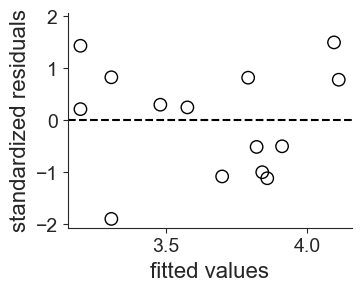

In [41]:
plot_panel_b(result_log_lm3)
plt.savefig(os.path.join(figpath3, 'fig_s1_1d3.png'),  bbox_inches='tight')
plt.savefig(os.path.join(figpath3, 'fig_s1_1d3.eps'),  bbox_inches='tight', format = 'eps', dpi= 300)

## 4. Fu data

In [42]:
pathdata4 = os.path.join(ectpath, 'data_Fu')
figpath4 = os.path.join(figs11panelpaths, 'data_Fu')
hfn.dir_check(figpath4)

In [43]:
df_raw4 = aicfn.import_data(pathdata4)
# log10 transformed datasets
df_log4 = hfn.make_log_df(df_raw4)

In [44]:
result_lm4, result_quad4, result_pl4, result_exp4, result_ln4, result_growth4, result_hill4 = fit_all_models(df_raw4, [2000, -100], [1000, 18, 4])

In [45]:
result_log_lm4, result_log_quad4 = fit_log_models(df_log4)

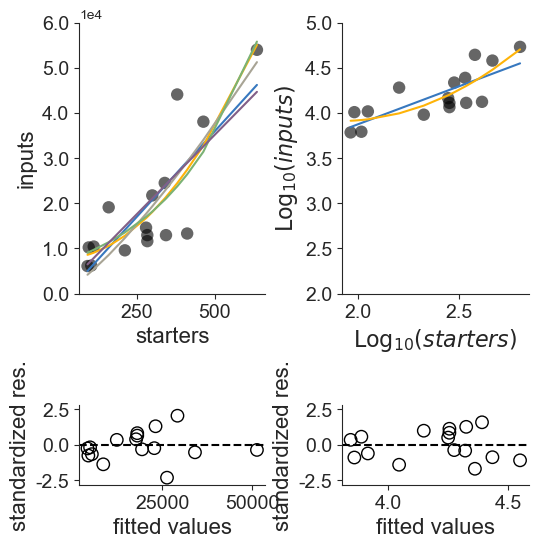

In [46]:
plot_fig(df_raw4, [result_lm4.best_fit, result_quad4.best_fit, result_pl4.best_fit, result_exp4.best_fit, result_growth4.best_fit], 6*10**4, result_pl4, df_log4, [result_log_lm4.best_fit, result_log_quad4.best_fit], 2, 5,result_log_lm4)
plt.savefig(os.path.join(figpath4, 'fig_s1_1.png'),  bbox_inches='tight')
plt.savefig(os.path.join(figpath4, 'fig_s1_1.eps'),  bbox_inches='tight', format = 'eps', dpi= 300)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


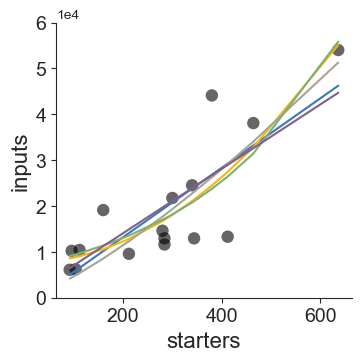

In [47]:
# Panel A1 : fit data in natural scale
plot_panel_a(df_raw4, [result_lm4.best_fit, result_quad4.best_fit, result_pl4.best_fit, result_exp4.best_fit, result_growth4.best_fit], 6*10**4)

plt.savefig(os.path.join(figpath4, 'fig_s1_1a4.png'),  bbox_inches='tight')
plt.savefig(os.path.join(figpath4, 'fig_s1_1a4.eps'),  bbox_inches='tight', format = 'eps', dpi= 300)

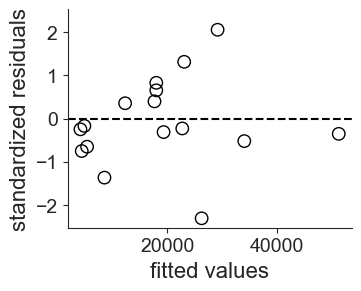

In [48]:
# Panel B1
plot_panel_b(result_pl4)
plt.savefig(os.path.join(figpath4, 'fig_s1_1b4.png'), bbox_inches='tight')
plt.savefig(os.path.join(figpath4, 'fig_s1_1b4.eps'), bbox_inches='tight', format = 'eps', dpi= 300)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


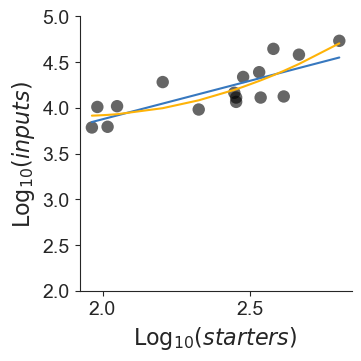

In [49]:
# Panel C1 : fit data in natural scale
plot_panel_c(df_log4, [result_log_lm4.best_fit, result_log_quad4.best_fit], 2, 5)
plt.savefig(os.path.join(figpath4, 'fig_s1_1c4.png'),  bbox_inches='tight')
plt.savefig(os.path.join(figpath4, 'fig_s1_1c4.eps'),  bbox_inches='tight', format = 'eps', dpi= 300)

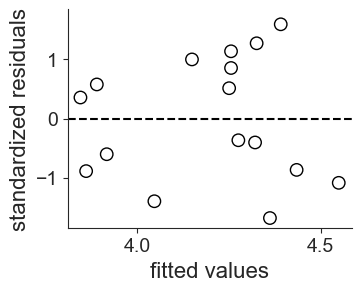

In [50]:
plot_panel_b(result_log_lm4)
plt.savefig(os.path.join(figpath4, 'fig_s1_1d4.png'), bbox_inches='tight')
plt.savefig(os.path.join(figpath4, 'fig_s1_1d4.eps'), bbox_inches='tight', format = 'eps', dpi= 300)

## 5. Gehrlach data

In [51]:
pathdata5 = os.path.join(ectpath, 'data_Gehrlach')
figpath5 = os.path.join(figs11panelpaths, 'data_Gehrlach')
hfn.dir_check(figpath5)

In [52]:
df_raw5 = aicfn.import_data(pathdata5)
# log10 transformed datasets
df_log5 = hfn.make_log_df(df_raw5)

In [53]:
result_lm5, result_quad5, result_pl5, result_exp5, result_ln5, result_growth5, result_hill5 = fit_all_models(df_raw5, [2000, -500], [6000, 5, 18])

In [54]:
result_log_lm5, result_log_quad5 = fit_log_models(df_log5)

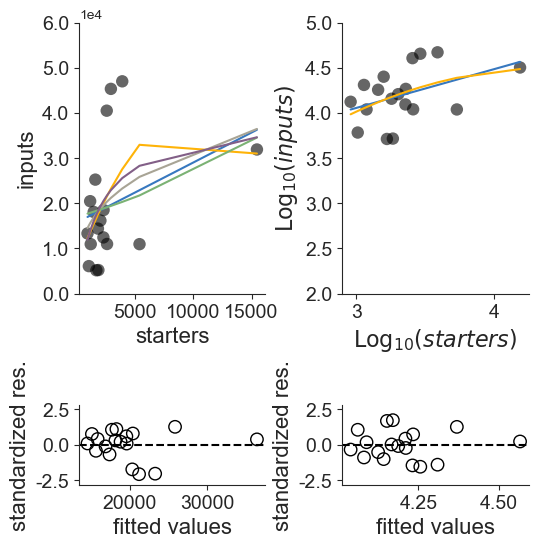

In [55]:
plot_fig(df_raw5, [result_lm5.best_fit, result_quad5.best_fit, result_pl5.best_fit, result_exp5.best_fit, result_growth5.best_fit], 6*10**4, result_pl5, df_log5, [result_log_lm5.best_fit, result_log_quad5.best_fit], 2, 5, result_log_lm5)
plt.savefig(os.path.join(figpath5, 'fig_s1_1.png'),  bbox_inches='tight')
plt.savefig(os.path.join(figpath5, 'fig_s1_1.eps'),  bbox_inches='tight', format = 'eps', dpi= 300)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


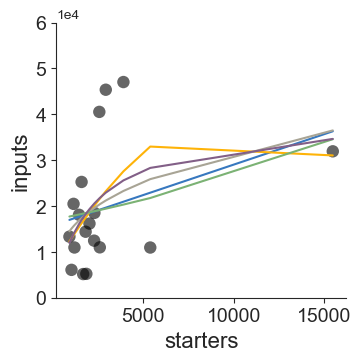

In [56]:
# Panel A1 : fit data in natural scale
plot_panel_a(df_raw5, [result_lm5.best_fit, result_quad5.best_fit, result_pl5.best_fit, result_exp5.best_fit, result_growth5.best_fit], 6*10**4)

plt.savefig(os.path.join(figpath5, 'fig_s1_1a5.png'),  bbox_inches='tight')
plt.savefig(os.path.join(figpath5, 'fig_s1_1a5.eps'),  bbox_inches='tight', format = 'eps', dpi= 300)

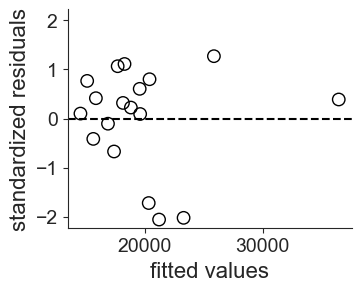

In [57]:
# Panel B1
plot_panel_b(result_pl5)
plt.savefig(os.path.join(figpath5, 'fig_s1_1b5.png'), bbox_inches='tight')
plt.savefig(os.path.join(figpath5, 'fig_s1_1b5.eps'), bbox_inches='tight', format = 'eps', dpi= 300)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


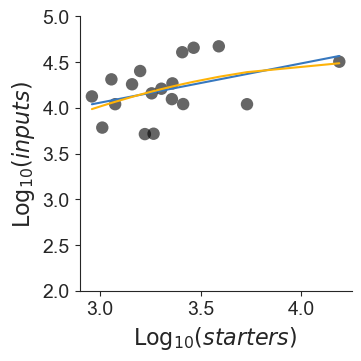

In [58]:
# Panel C1 : fit data in natural scale
plot_panel_c(df_log5, [result_log_lm5.best_fit, result_log_quad5.best_fit], 2, 5)
plt.savefig(os.path.join(figpath5, 'fig_s1_1c5.png'),  bbox_inches='tight')
plt.savefig(os.path.join(figpath5, 'fig_s1_1c5.eps'),  bbox_inches='tight', format = 'eps', dpi= 300)

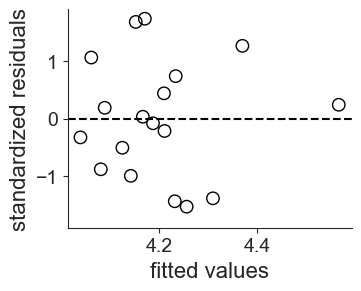

In [59]:
plot_panel_b(result_log_lm5)
plt.savefig(os.path.join(figpath5, 'fig_s1_1d5.png'), bbox_inches='tight')
plt.savefig(os.path.join(figpath5, 'fig_s1_1d5.eps'), bbox_inches='tight', format = 'eps', dpi= 300)

## 6. Hafner data

In [60]:
pathdata6 = os.path.join(ectpath, 'data_Hafner')
figpath6 = os.path.join(figs11panelpaths, 'data_Hafner')
hfn.dir_check(figpath6)

In [61]:
df_raw6 = aicfn.import_data(pathdata6)
# log10 transformed datasets
df_log6 = hfn.make_log_df(df_raw6)

In [62]:
result_lm6, result_quad6, result_pl6, result_exp6, result_ln6, result_growth6, result_hill6 = fit_all_models(df_raw6, [2000, -500], [6000, 5, 18])

In [63]:
result_log_lm6, result_log_quad6 = fit_log_models(df_log6)

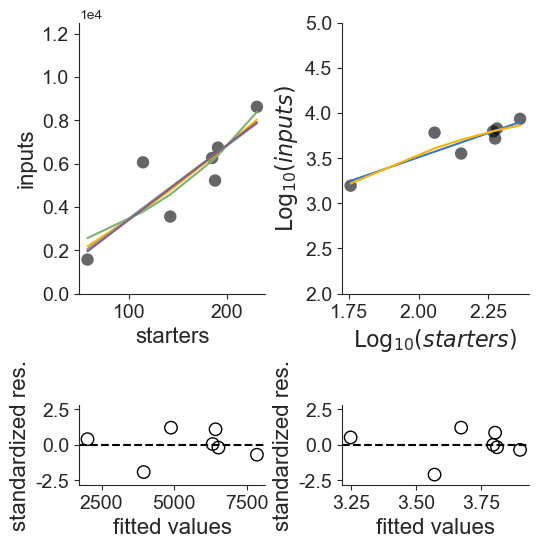

In [64]:
plot_fig(df_raw6, [result_lm6.best_fit, result_quad6.best_fit, result_pl6.best_fit, result_exp6.best_fit, result_growth6.best_fit], 1.25*10**4, result_pl6, df_log6, [result_log_lm6.best_fit, result_log_quad6.best_fit], 2, 5, result_log_lm6)
plt.savefig(os.path.join(figpath6, 'fig_s1_1.png'),  bbox_inches='tight')
plt.savefig(os.path.join(figpath6, 'fig_s1_1.eps'),  bbox_inches='tight', format = 'eps', dpi= 300)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


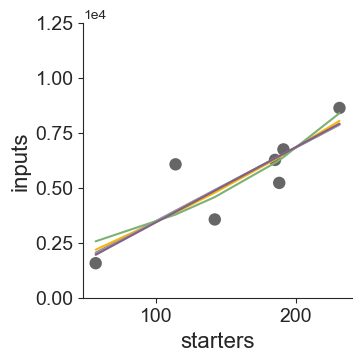

In [65]:
# Panel A1 : fit data in natural scale
plot_panel_a(df_raw6, [result_lm6.best_fit, result_quad6.best_fit, result_pl6.best_fit, result_exp6.best_fit, result_growth6.best_fit], 1.25*10**4)

plt.savefig(os.path.join(figpath6, 'fig_s1_1a6.png'),  bbox_inches='tight')
plt.savefig(os.path.join(figpath6, 'fig_s1_1a6.eps'),  bbox_inches='tight', format = 'eps', dpi= 300)

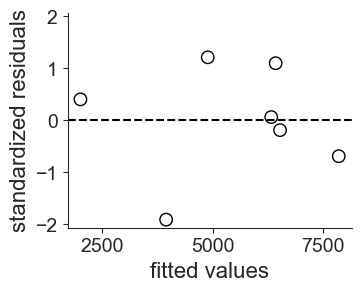

In [66]:
# Panel B1
plot_panel_b(result_pl6)
plt.savefig(os.path.join(figpath6, 'fig_s1_1b6.png'), bbox_inches='tight')
plt.savefig(os.path.join(figpath6, 'fig_s1_1b6.eps'), bbox_inches='tight', format = 'eps', dpi= 300)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


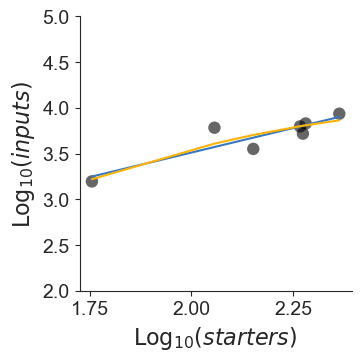

In [67]:
# Panel C1 : fit data in natural scale
plot_panel_c(df_log6, [result_log_lm6.best_fit, result_log_quad6.best_fit], 2, 5)
plt.savefig(os.path.join(figpath6, 'fig_s1_1c6.png'),  bbox_inches='tight')
plt.savefig(os.path.join(figpath6, 'fig_s1_1c6.eps'),  bbox_inches='tight', format = 'eps', dpi= 300)

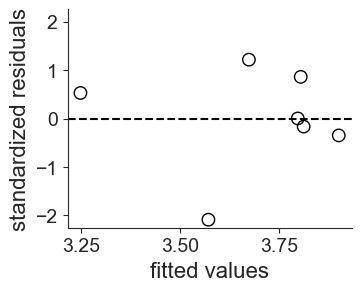

In [68]:
plot_panel_b(result_log_lm6)
plt.savefig(os.path.join(figpath6, 'fig_s1_1d6.png'), bbox_inches='tight')
plt.savefig(os.path.join(figpath6, 'fig_s1_1d6.eps'), bbox_inches='tight', format = 'eps', dpi= 300)

## 7. Kim data

In [69]:
pathdata7 = os.path.join(ectpath, 'data_Kim_2015')
figpath7 = os.path.join(figs11panelpaths, 'data_Kim_2015')
hfn.dir_check(figpath7)

In [70]:
df_raw7 = aicfn.import_data(pathdata7)
# log10 transformed datasets
df_log7 = hfn.make_log_df(df_raw7)

In [71]:
result_lm7, result_quad7, result_pl7, result_exp7, result_ln7, result_growth7, result_hill7= fit_all_models(df_raw7, [2000, -500], [6000, 5, 18])

In [72]:
result_log_lm7, result_log_quad7 = fit_log_models(df_log7)

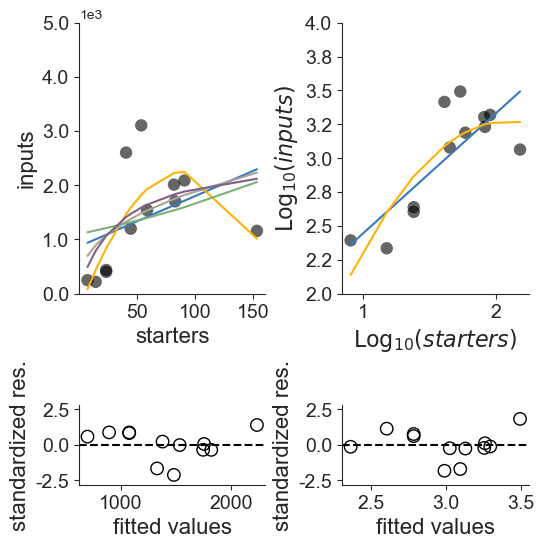

In [73]:
plot_fig(df_raw7, [result_lm7.best_fit, result_quad7.best_fit, result_pl7.best_fit, result_exp7.best_fit, result_growth7.best_fit], 0.5*10**4, result_pl7, df_log7, [result_log_lm7.best_fit, result_log_quad7.best_fit], 2, 4, result_log_lm7)
plt.savefig(os.path.join(figpath7, 'fig_s1_1.png'),  bbox_inches='tight')
plt.savefig(os.path.join(figpath7, 'fig_s1_1.eps'),  bbox_inches='tight', format = 'eps', dpi= 300)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


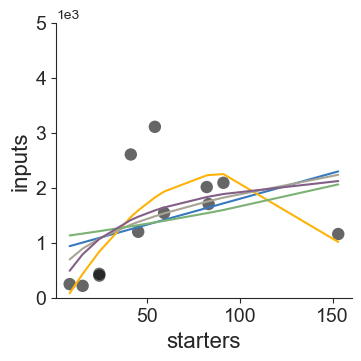

In [74]:
# Panel A1 : fit data in natural scale
plot_panel_a(df_raw7, [result_lm7.best_fit, result_quad7.best_fit, result_pl7.best_fit, result_exp7.best_fit, result_growth7.best_fit], 0.5*10**4)

plt.savefig(os.path.join(figpath7, 'fig_s1_1a7.png'),  bbox_inches='tight')
plt.savefig(os.path.join(figpath7, 'fig_s1_1a7.eps'),  bbox_inches='tight', format = 'eps', dpi= 300)

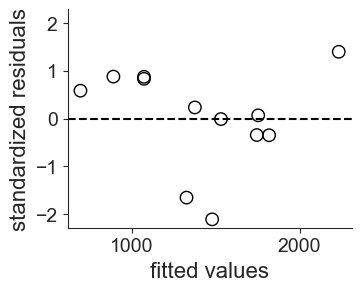

In [75]:
# Panel B1
plot_panel_b(result_pl7)
plt.savefig(os.path.join(figpath7, 'fig_s1_1b7.png'), bbox_inches='tight')
plt.savefig(os.path.join(figpath7, 'fig_s1_1b7.eps'), bbox_inches='tight', format = 'eps', dpi= 300)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


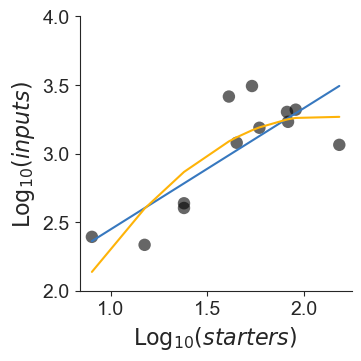

In [76]:
# Panel C1 : fit data in natural scale
plot_panel_c(df_log7, [result_log_lm7.best_fit, result_log_quad7.best_fit], 2, 4)
plt.savefig(os.path.join(figpath7, 'fig_s1_1c7.png'),  bbox_inches='tight')
plt.savefig(os.path.join(figpath7, 'fig_s1_1c7.eps'),  bbox_inches='tight', format = 'eps', dpi= 300)

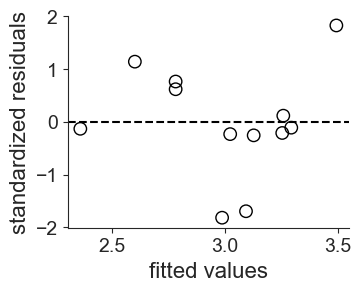

In [77]:
plot_panel_b(result_log_lm7)
plt.savefig(os.path.join(figpath7, 'fig_s1_1d7.png'), bbox_inches='tight')
plt.savefig(os.path.join(figpath7, 'fig_s1_1d7.eps'), bbox_inches='tight', format = 'eps', dpi= 300)

## 8. Pouchelon data

In [78]:
pathdata8 = os.path.join(ectpath, 'data_Pouchelon')
figpath8 = os.path.join(figs11panelpaths, 'data_Pouchelon')
hfn.dir_check(figpath8)

In [79]:
df_raw8 = aicfn.import_data(pathdata8)
# log10 transformed datasets
df_log8 = hfn.make_log_df(df_raw8)

In [80]:
df_raw8.head()

,ID,starter,input,condition,cell_type
0,28,32,232,PV_V1_P5,interneuron
1,40,36,1896,SST_V1_P5,interneuron
2,34,40,3000,SST_M2_P5,interneuron
3,22,52,404,PV_M2_P5,interneuron
4,19,64,3856,PV_V1_P30,interneuron


In [81]:
df_raw8_p5 = df_raw8[df_raw8.condition.str.endswith('P5')]
df_raw8_p30 = df_raw8[df_raw8.condition.str.endswith('P30')]

In [82]:
# log10 transformed datasets
df_log8_p5 = hfn.make_log_df(df_raw8_p5)
df_log8_p30 = hfn.make_log_df(df_raw8_p30)

In [83]:
result_lm8, result_quad8, result_pl8, result_exp8, result_ln8, result_growth8, result_hill8 = fit_all_models(df_raw8, [2000, -500], [6000, 5, 18])

In [84]:
result_log_lm8, result_log_quad8 = fit_log_models(df_log8)

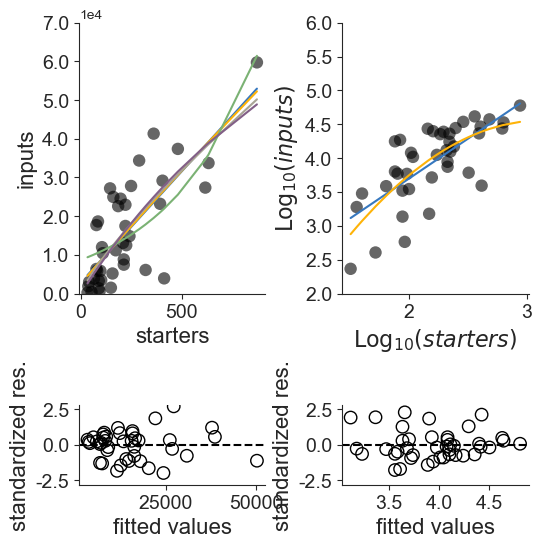

In [85]:
plot_fig(df_raw8, [result_lm8.best_fit, result_quad8.best_fit, result_pl8.best_fit, result_exp8.best_fit, result_growth8.best_fit], 7*10**4, result_pl8, df_log8, [result_log_lm8.best_fit, result_log_quad8.best_fit], 2, 6, result_log_lm8)
plt.savefig(os.path.join(figpath8, 'fig_s1_1.png'),  bbox_inches='tight')
plt.savefig(os.path.join(figpath8, 'fig_s1_1.eps'),  bbox_inches='tight', format = 'eps', dpi= 300)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


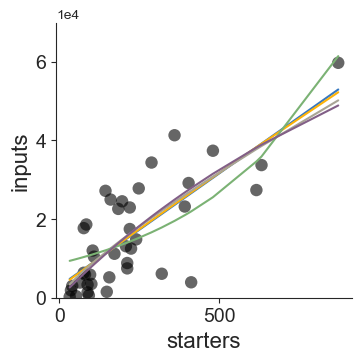

In [86]:
# Panel A1 : fit data in natural scale
plot_panel_a(df_raw8, [result_lm8.best_fit, result_quad8.best_fit, result_pl8.best_fit, result_exp8.best_fit, result_growth8.best_fit], 7*10**4)

plt.savefig(os.path.join(figpath8, 'fig_s1_1a8.png'),  bbox_inches='tight')
plt.savefig(os.path.join(figpath8, 'fig_s1_1a8.eps'),  bbox_inches='tight', format = 'eps', dpi= 300)

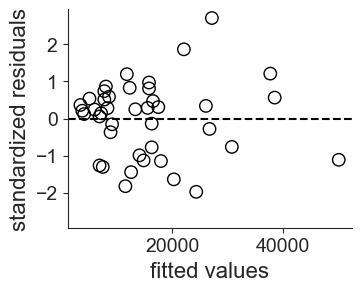

In [87]:
# Panel B1
plot_panel_b(result_pl8)
plt.savefig(os.path.join(figpath8, 'fig_s1_1b8.png'), bbox_inches='tight')
plt.savefig(os.path.join(figpath8, 'fig_s1_1b8.eps'), bbox_inches='tight', format = 'eps', dpi= 300)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


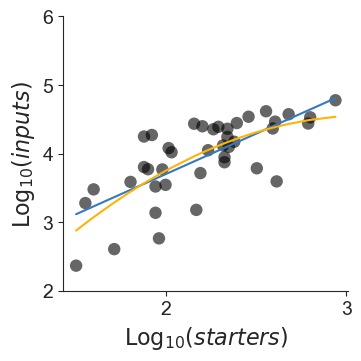

In [88]:
# Panel C1 : fit data in natural scale
plot_panel_c(df_log8, [result_log_lm8.best_fit, result_log_quad8.best_fit], 2, 6)
plt.savefig(os.path.join(figpath8, 'fig_s1_1c8.png'),  bbox_inches='tight')
plt.savefig(os.path.join(figpath8, 'fig_s1_1c8.eps'),  bbox_inches='tight', format = 'eps', dpi= 300)

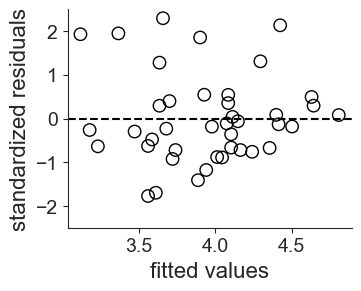

In [89]:
plot_panel_b(result_log_lm8)
plt.savefig(os.path.join(figpath8, 'fig_s1_1d8.png'), bbox_inches='tight')
plt.savefig(os.path.join(figpath8, 'fig_s1_1d8.eps'), bbox_inches='tight', format = 'eps', dpi= 300)

In [90]:
result_lm8_p5, result_quad8_p5, result_pl8_p5, result_exp8_p5, result_ln8_p5, result_growth8_p5, result_hill8_p5 = fit_all_models(df_raw8_p5, [2000, -500], [6000, 5, 18])
result_lm8_p30, result_quad8_p30, result_pl8_p30, result_exp8_p30, result_ln8_p30, result_growth8_p30, result_hill8_p30 = fit_all_models(df_raw8_p30, [2000, -500], [6000, 5, 18])

In [91]:
result_log_lm8_p5, result_log_quad8_p5 = fit_log_models(df_log8_p5)
result_log_lm8_p30, result_log_quad8_p30 = fit_log_models(df_log8_p30)

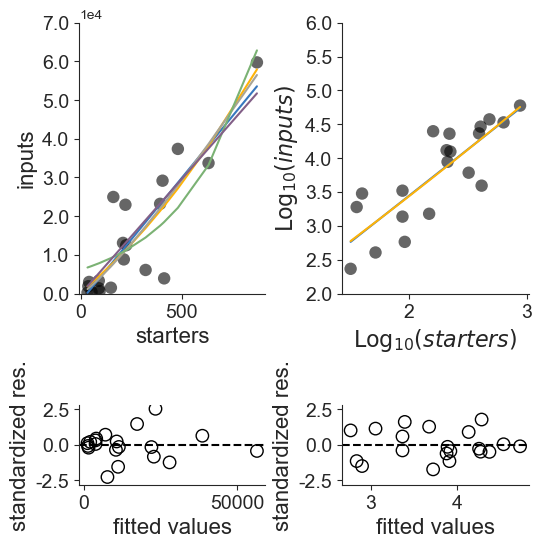

In [92]:
plot_fig(df_raw8_p5, [result_lm8_p5.best_fit, result_quad8_p5.best_fit, result_pl8_p5.best_fit, result_exp8_p5.best_fit, result_growth8_p5.best_fit], 7*10**4, result_pl8_p5, df_log8_p5, [result_log_lm8_p5.best_fit, result_log_quad8_p5.best_fit], 2, 6, result_log_lm8_p5)
plt.savefig(os.path.join(figpath8, 'fig_s1_1_p5.png'),  bbox_inches='tight')
plt.savefig(os.path.join(figpath8, 'fig_s1_1_p5.eps'),  bbox_inches='tight', format = 'eps', dpi= 300)

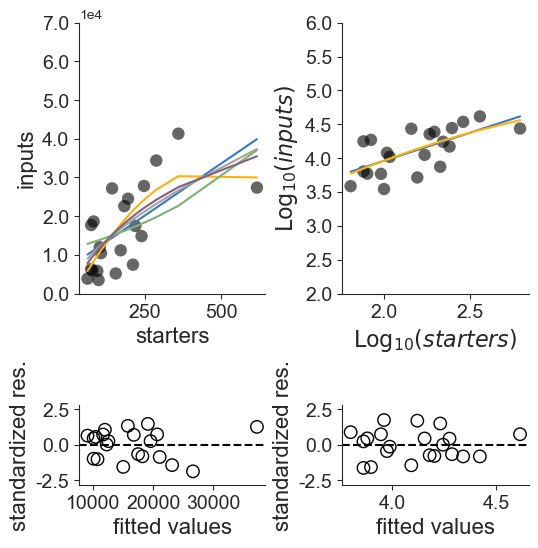

In [93]:
plot_fig(df_raw8_p30, [result_lm8_p30.best_fit, result_quad8_p30.best_fit, result_pl8_p30.best_fit, result_exp8_p30.best_fit, result_growth8_p30.best_fit], 7*10**4, result_pl8_p30, df_log8_p30, [result_log_lm8_p30.best_fit, result_log_quad8_p30.best_fit], 2, 6, result_log_lm8_p30)
plt.savefig(os.path.join(figpath8, 'fig_s1_1_p30.png'),  bbox_inches='tight')
plt.savefig(os.path.join(figpath8, 'fig_s1_1_p30.eps'),  bbox_inches='tight', format = 'eps', dpi= 300)

## 9. Sun data

In [94]:
pathdata9 = os.path.join(ectpath, 'data_Sunetal')
figpath9 = os.path.join(figs11panelpaths, 'data_Sun')
hfn.dir_check(figpath9)

In [95]:
df_raw9 = aicfn.import_data(pathdata9)
# log10 transformed datasets
df_log9 = hfn.make_log_df(df_raw9)

In [96]:
result_lm9, result_quad9, result_pl9, result_exp9, result_ln9, result_growth9, result_hill9 = fit_all_models(df_raw9, [2000, -500], [6000, 5, 18])

In [97]:
result_log_lm9, result_log_quad9 = fit_log_models(df_log9)

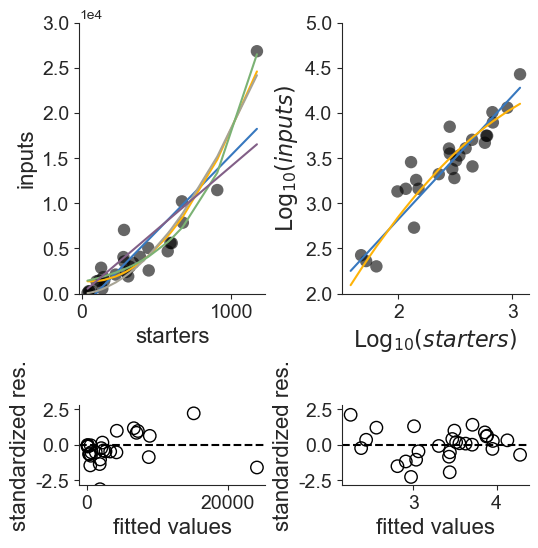

In [98]:
plot_fig(df_raw9, [result_lm9.best_fit, result_quad9.best_fit, result_pl9.best_fit, result_exp9.best_fit, result_growth9.best_fit], 3*10**4, result_pl9, df_log9, [result_log_lm9.best_fit, result_log_quad9.best_fit], 2, 5, result_log_lm9)
plt.savefig(os.path.join(figpath9, 'fig_s1_1.png'),  bbox_inches='tight')
plt.savefig(os.path.join(figpath9, 'fig_s1_1.eps'),  bbox_inches='tight', format = 'eps', dpi= 300)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


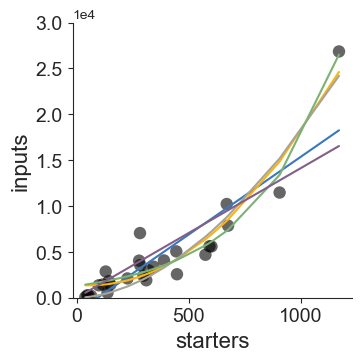

In [99]:
# Panel A1 : fit data in natural scale
plot_panel_a(df_raw9, [result_lm9.best_fit, result_quad9.best_fit, result_pl9.best_fit, result_exp9.best_fit, result_growth9.best_fit], 3*10**4)

plt.savefig(os.path.join(figpath9, 'fig_s1_1a9.png'),  bbox_inches='tight')
plt.savefig(os.path.join(figpath9, 'fig_s1_1a9.eps'),  bbox_inches='tight', format = 'eps', dpi= 300)

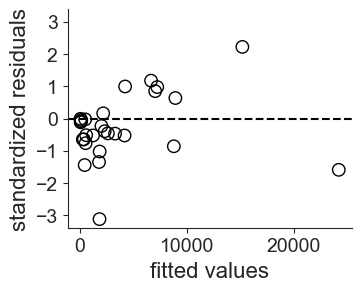

In [100]:
# Panel B1
plot_panel_b(result_pl9)
plt.savefig(os.path.join(figpath9, 'fig_s1_1b9.png'), bbox_inches='tight')
plt.savefig(os.path.join(figpath9, 'fig_s1_1b9.eps'), bbox_inches='tight', format = 'eps', dpi= 300)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


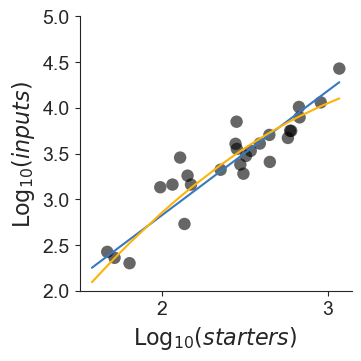

In [101]:
# Panel C1 : fit data in natural scale
plot_panel_c(df_log9, [result_log_lm9.best_fit, result_log_quad9.best_fit], 2, 5)
plt.savefig(os.path.join(figpath9, 'fig_s1_1c9.png'),  bbox_inches='tight')
plt.savefig(os.path.join(figpath9, 'fig_s1_1c9.eps'),  bbox_inches='tight', format = 'eps', dpi= 300)

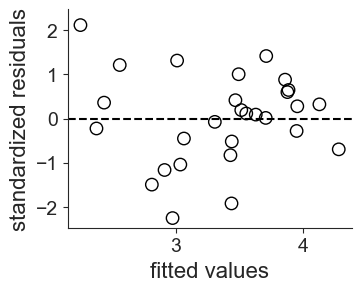

In [102]:
plot_panel_b(result_log_lm9)
plt.savefig(os.path.join(figpath9, 'fig_s1_1d9.png'), bbox_inches='tight')
plt.savefig(os.path.join(figpath9, 'fig_s1_1d9.eps'), bbox_inches='tight', format = 'eps', dpi= 300)

## 10. Wee data

In [103]:
pathdata10 = os.path.join(ectpath, 'data_Wee')
figpath10 = os.path.join(figs11panelpaths, 'data_Wee')
hfn.dir_check(figpath10)

In [104]:
df_raw10 = aicfn.import_data(pathdata10)
# log10 transformed datasets
df_log10 = hfn.make_log_df(df_raw10)

In [105]:
result_lm10, result_quad10, result_pl10, result_exp10, result_ln10, result_growth10, result_hill10 = fit_all_models(df_raw10, [2000, -500], [6000, 5, 18])

In [106]:
result_log_lm10, result_log_quad10 = fit_log_models(df_log10)

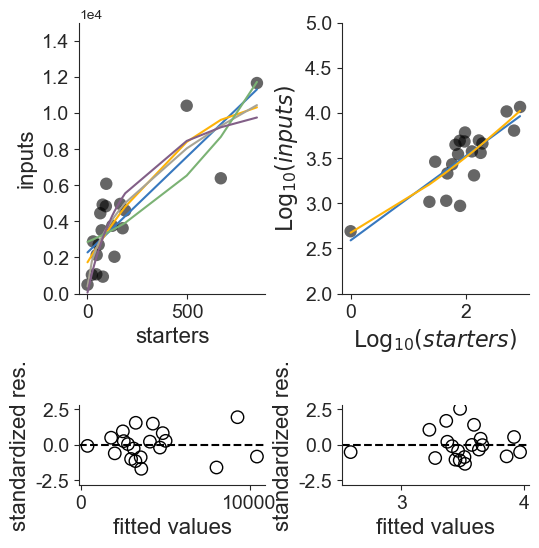

In [107]:
plot_fig(df_raw10, [result_lm10.best_fit, result_quad10.best_fit, result_pl10.best_fit, result_exp10.best_fit, result_growth10.best_fit], 1.5*10**4, result_pl10, df_log10, [result_log_lm10.best_fit, result_log_quad10.best_fit], 2, 5, result_log_lm10)
plt.savefig(os.path.join(figpath10, 'fig_s1_1.png'),  bbox_inches='tight')
plt.savefig(os.path.join(figpath10, 'fig_s1_1.eps'),  bbox_inches='tight', format = 'eps', dpi= 300)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


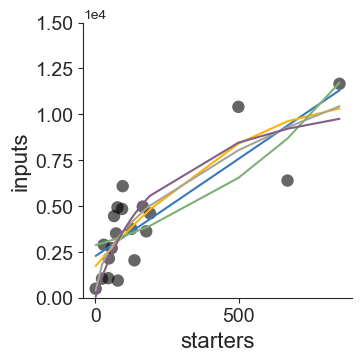

In [108]:
# Panel A1 : fit data in natural scale
plot_panel_a(df_raw10, [result_lm10.best_fit, result_quad10.best_fit, result_pl10.best_fit, result_exp10.best_fit, result_growth10.best_fit], 1.5*10**4)

plt.savefig(os.path.join(figpath10, 'fig_s1_1a10.png'),  bbox_inches='tight')
plt.savefig(os.path.join(figpath10, 'fig_s1_1a10.eps'),  bbox_inches='tight', format = 'eps', dpi= 300)

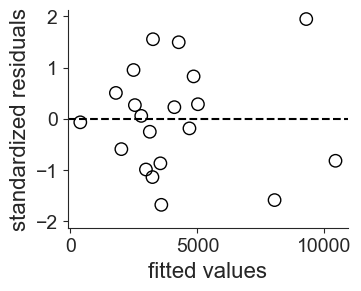

In [109]:
# Panel B1
plot_panel_b(result_pl10)
plt.savefig(os.path.join(figpath10, 'fig_s1_1b10.png'), bbox_inches='tight')
plt.savefig(os.path.join(figpath10, 'fig_s1_1b10.eps'), bbox_inches='tight', format = 'eps', dpi= 300)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


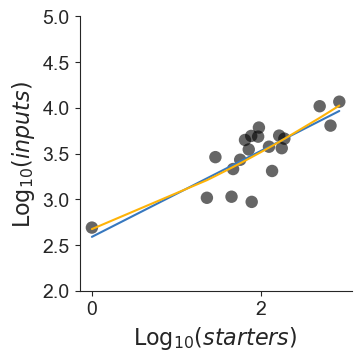

In [110]:
# Panel C1 : fit data in natural scale
plot_panel_c(df_log10, [result_log_lm10.best_fit, result_log_quad10.best_fit], 2, 5)
plt.savefig(os.path.join(figpath10, 'fig_s1_1c10.png'),  bbox_inches='tight')
plt.savefig(os.path.join(figpath10, 'fig_s1_1c10.eps'),  bbox_inches='tight', format = 'eps', dpi= 300)

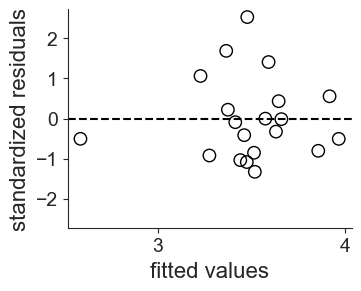

In [111]:
plot_panel_b(result_log_lm10)
plt.savefig(os.path.join(figpath10, 'fig_s1_1d10.png'), bbox_inches='tight')
plt.savefig(os.path.join(figpath10, 'fig_s1_1d10.eps'), bbox_inches='tight', format = 'eps', dpi= 300)

## 11. Allen data

In [112]:
pathdata11 = os.path.join(ectpath, 'data_Allen')
figpath11 = os.path.join(figs11panelpaths, 'data_Allen')
hfn.dir_check(figpath11)

In [113]:
df_raw11 = aicfn.import_data(pathdata11)
# log10 transformed datasets
df_log11 = hfn.make_log_df(df_raw11)

In [114]:
result_lm11, result_quad11, result_pl11, result_exp11, result_ln11, result_growth11, result_hill11 = fit_all_models(df_raw11, [2000, -500], [6000, 5, 18])

In [115]:
result_log_lm11, result_log_quad11 = fit_log_models(df_log11)

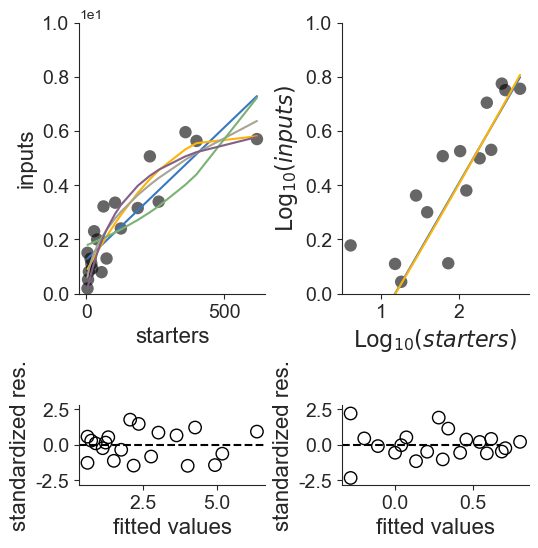

In [116]:
plot_fig(df_raw11, [result_lm11.best_fit, result_quad11.best_fit, result_pl11.best_fit, result_exp11.best_fit,  result_growth11.best_fit], 1.0*10**1, result_pl11, df_log11, [result_log_lm11.best_fit, result_log_quad11.best_fit], 0, 1.0, result_log_lm11)
plt.savefig(os.path.join(figpath11, 'fig_s1_1.png'),  bbox_inches='tight')
plt.savefig(os.path.join(figpath11, 'fig_s1_1.eps'),  bbox_inches='tight', format = 'eps', dpi= 300)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


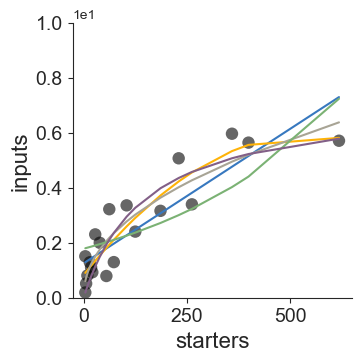

In [117]:
# Panel A1 : fit data in natural scale
plot_panel_a(df_raw11, [result_lm11.best_fit, result_quad11.best_fit, result_pl11.best_fit, result_exp11.best_fit, result_growth11.best_fit], 1.*10**1)

plt.savefig(os.path.join(figpath11, 'fig_s1_1a11.png'),  bbox_inches='tight')
plt.savefig(os.path.join(figpath11, 'fig_s1_1a11.eps'),  bbox_inches='tight', format = 'eps', dpi= 300)

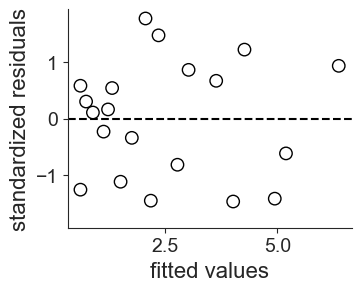

In [118]:
# Panel B1
plot_panel_b(result_pl11)
plt.savefig(os.path.join(figpath11, 'fig_s1_1b11.png'), bbox_inches='tight')
plt.savefig(os.path.join(figpath11, 'fig_s1_1b11.eps'), bbox_inches='tight', format = 'eps', dpi= 300)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


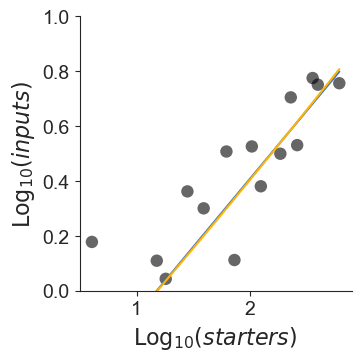

In [119]:
# Panel C1 : fit data in natural scale
plot_panel_c(df_log11, [result_log_lm11.best_fit, result_log_quad11.best_fit], 0, 1)
plt.savefig(os.path.join(figpath11, 'fig_s1_1c11.png'),  bbox_inches='tight')
plt.savefig(os.path.join(figpath11, 'fig_s1_1c11.eps'),  bbox_inches='tight', format = 'eps', dpi= 300)

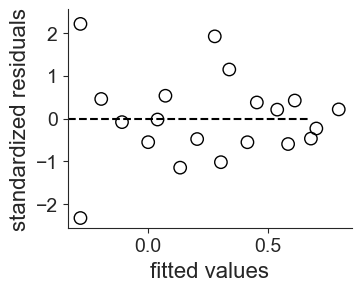

In [120]:
plot_panel_b(result_log_lm11)
plt.savefig(os.path.join(figpath11, 'fig_s1_1d11.png'), bbox_inches='tight')
plt.savefig(os.path.join(figpath11, 'fig_s1_1d11.eps'), bbox_inches='tight', format = 'eps', dpi= 300)

## 12. Takatoh data

In [121]:
pathdata12 = os.path.join(ectpath, 'data_Takatoh')
figpath12 = os.path.join(figs11panelpaths, 'data_Takatoh')
hfn.dir_check(figpath12)

In [122]:
df_raw12 = aicfn.import_data(pathdata12).dropna()
# log10 transformed datasets
df_log12 = hfn.make_log_df(df_raw12)

In [123]:
result_lm12, result_quad12, result_pl12, result_exp12, result_ln12, result_growth12, result_hill12 = fit_all_models(df_raw12, [1000, -500], [6000, 5, 18])

In [124]:
result_log_lm12, result_log_quad12 = fit_log_models(df_log12)

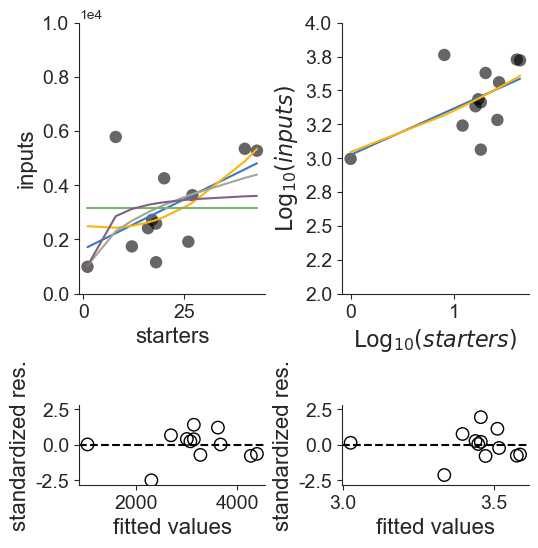

In [125]:
plot_fig(df_raw12, [result_lm12.best_fit, result_quad12.best_fit, result_pl12.best_fit, result_exp12.best_fit, result_growth12.best_fit], 1*10**4, result_pl12, df_log12, [result_log_lm12.best_fit, result_log_quad12.best_fit], 2, 4,result_log_lm12)
plt.savefig(os.path.join(figpath12, 'fig_s1_1.png'),  bbox_inches='tight')
plt.savefig(os.path.join(figpath12, 'fig_s1_1.eps'),  bbox_inches='tight', format = 'eps', dpi= 300)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


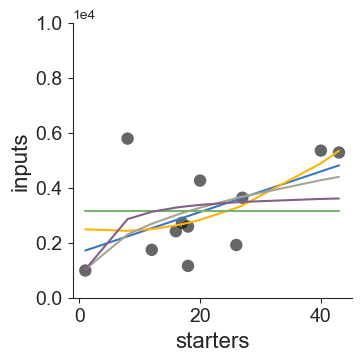

In [126]:
# Panel A1 : fit data in natural scale
plot_panel_a(df_raw12, [result_lm12.best_fit, result_quad12.best_fit, result_pl12.best_fit, result_exp12.best_fit, result_growth12.best_fit], 1*10**4)

plt.savefig(os.path.join(figpath12, 'fig_s1_1a1.png'),  bbox_inches='tight')
plt.savefig(os.path.join(figpath12, 'fig_s1_1a1.eps'),  bbox_inches='tight', format = 'eps', dpi= 300)

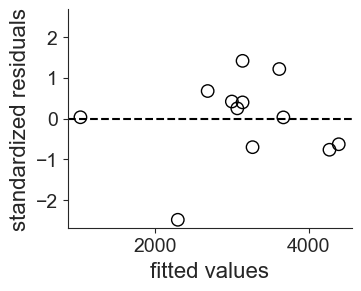

In [127]:
# Panel B1
plot_panel_b(result_pl12)
plt.savefig(os.path.join(figpath12, 'fig_s1_1b1.png'),  bbox_inches='tight')
plt.savefig(os.path.join(figpath12, 'fig_s1_1b1.eps'),  bbox_inches='tight', format = 'eps', dpi= 300)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


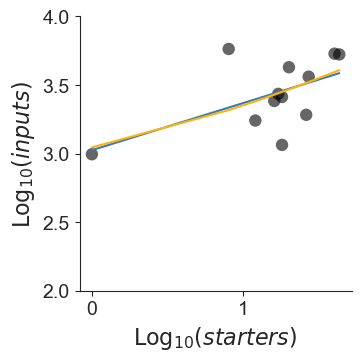

In [128]:
# Panel C1 : fit data in natural scale
plot_panel_c(df_log12, [result_log_lm12.best_fit, result_log_quad12.best_fit], 2, 4)
plt.savefig(os.path.join(figpath12, 'fig_s1_1c1.png'),  bbox_inches='tight')
plt.savefig(os.path.join(figpath12, 'fig_s1_1c1.eps'),  bbox_inches='tight', format = 'eps', dpi= 300)

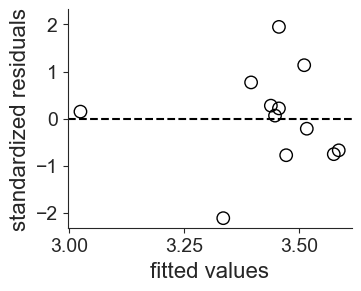

In [129]:
plot_panel_b(result_log_lm12)
plt.savefig(os.path.join(figpath12, 'fig_s1_1d1.png'),  bbox_inches='tight')
plt.savefig(os.path.join(figpath12, 'fig_s1_1d1.eps'),  bbox_inches='tight', format = 'eps', dpi= 300)

## 13. Graham data - interneurons

In [130]:
pathdata13 = os.path.join(ectpath, 'data_Graham_interneuron')
figpath13 = os.path.join(figs11panelpaths, 'data_Graham_interneuron')
hfn.dir_check(figpath13)

In [131]:
df_raw13 = aicfn.import_data(pathdata13).dropna()
# log10 transformed datasets
df_log13 = hfn.make_log_df(df_raw13)

In [132]:
result_lm13, result_quad13, result_pl13, result_exp13, result_ln13, result_growth13, result_hill13 = fit_all_models(df_raw13, [1000, -500], [6000, 5, 18])

In [133]:
result_log_lm13, result_log_quad13 = fit_log_models(df_log13)

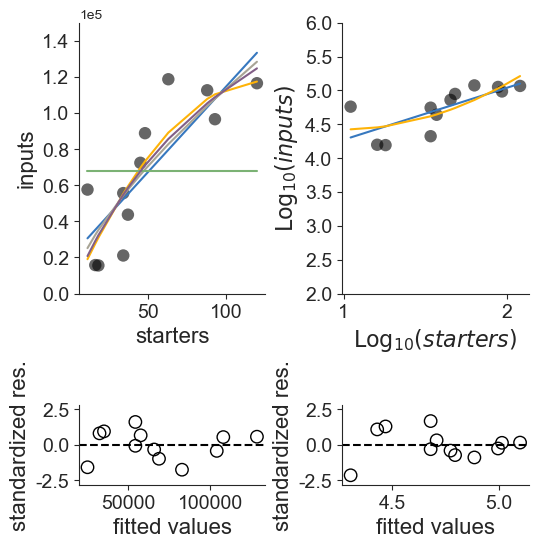

In [134]:
plot_fig(df_raw13, [result_lm13.best_fit, result_quad13.best_fit, result_pl13.best_fit, result_exp13.best_fit, result_growth13.best_fit], 1.5*10**5, result_pl13, df_log13, [result_log_lm13.best_fit, result_log_quad13.best_fit], 2, 6,result_log_lm13)
plt.savefig(os.path.join(figpath13, 'fig_s1_1.png'),  bbox_inches='tight')
plt.savefig(os.path.join(figpath13, 'fig_s1_1.eps'),  bbox_inches='tight', format = 'eps', dpi= 300)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


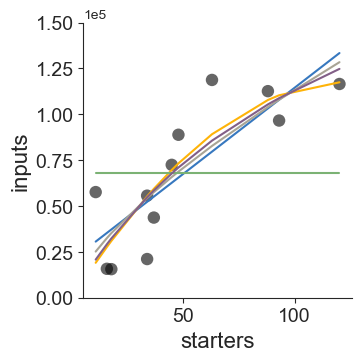

In [135]:
# Panel A1 : fit data in natural scale
plot_panel_a(df_raw13, [result_lm13.best_fit, result_quad13.best_fit, result_pl13.best_fit, result_exp13.best_fit, result_growth13.best_fit], 1.5*10**5)

plt.savefig(os.path.join(figpath13, 'fig_s1_1a1.png'),  bbox_inches='tight')
plt.savefig(os.path.join(figpath13, 'fig_s1_1a1.eps'),  bbox_inches='tight', format = 'eps', dpi= 300)

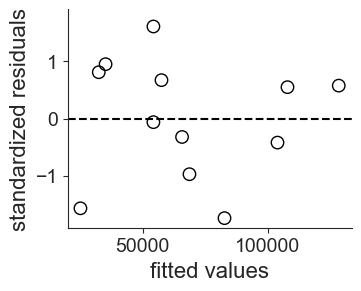

In [136]:
# Panel B1
plot_panel_b(result_pl13)
plt.savefig(os.path.join(figpath13, 'fig_s1_1b1.png'),  bbox_inches='tight')
plt.savefig(os.path.join(figpath13, 'fig_s1_1b1.eps'),  bbox_inches='tight', format = 'eps', dpi= 300)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


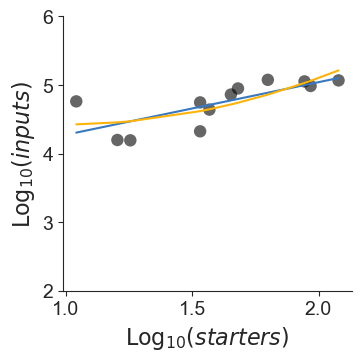

In [137]:
# Panel C1 : fit data in natural scale
plot_panel_c(df_log13, [result_log_lm13.best_fit, result_log_quad13.best_fit], 2, 6)
plt.savefig(os.path.join(figpath13, 'fig_s1_1c1.png'),  bbox_inches='tight')
plt.savefig(os.path.join(figpath13, 'fig_s1_1c1.eps'),  bbox_inches='tight', format = 'eps', dpi= 300)

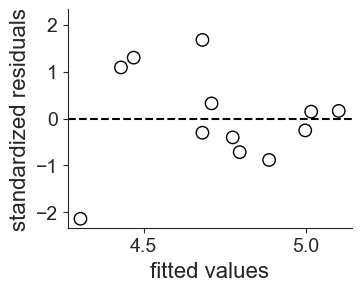

In [138]:
plot_panel_b(result_log_lm13)
plt.savefig(os.path.join(figpath13, 'fig_s1_1d1.png'),  bbox_inches='tight')
plt.savefig(os.path.join(figpath13, 'fig_s1_1d1.eps'),  bbox_inches='tight', format = 'eps', dpi= 300)

## 14. Graham data - projection

In [139]:
pathdata14 = os.path.join(ectpath, 'data_Graham_projection')
figpath14 = os.path.join(figs11panelpaths, 'data_Graham_projection')
hfn.dir_check(figpath14)

In [140]:
df_raw14 = aicfn.import_data(pathdata14).dropna()
# log10 transformed datasets
df_log14 = hfn.make_log_df(df_raw14)

In [141]:
result_lm14, result_quad14, result_pl14, result_exp14, result_ln14, result_growth14, result_hill14 = fit_all_models(df_raw14, [1000, -500], [6000, 5, 18])

In [142]:
result_log_lm14, result_log_quad14 = fit_log_models(df_log14)

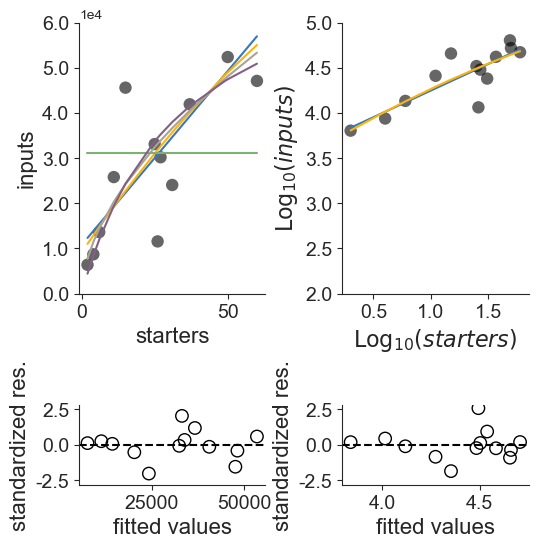

In [143]:
plot_fig(df_raw14, [result_lm14.best_fit, result_quad14.best_fit, result_pl14.best_fit, result_exp14.best_fit, result_growth14.best_fit], 6*10**4, result_pl14, df_log14, [result_log_lm14.best_fit, result_log_quad14.best_fit], 2, 5,result_log_lm14)
plt.savefig(os.path.join(figpath14, 'fig_s1_1.png'),  bbox_inches='tight')
plt.savefig(os.path.join(figpath14, 'fig_s1_1.eps'),  bbox_inches='tight', format = 'eps', dpi= 300)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


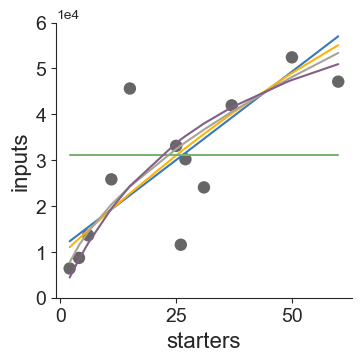

In [144]:
# Panel A1 : fit data in natural scale
plot_panel_a(df_raw14, [result_lm14.best_fit, result_quad14.best_fit, result_pl14.best_fit, result_exp14.best_fit, result_growth14.best_fit], 6*10**4)

plt.savefig(os.path.join(figpath14, 'fig_s1_1a1.png'),  bbox_inches='tight')
plt.savefig(os.path.join(figpath14, 'fig_s1_1a1.eps'),  bbox_inches='tight', format = 'eps', dpi= 300)

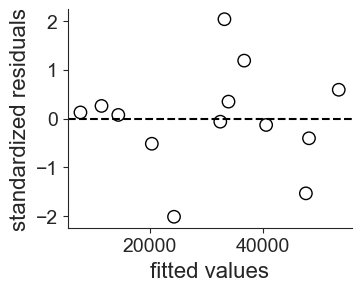

In [145]:
# Panel B1
plot_panel_b(result_pl14)
plt.savefig(os.path.join(figpath14, 'fig_s1_1b1.png'),  bbox_inches='tight')
plt.savefig(os.path.join(figpath14, 'fig_s1_1b1.eps'),  bbox_inches='tight', format = 'eps', dpi= 300)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


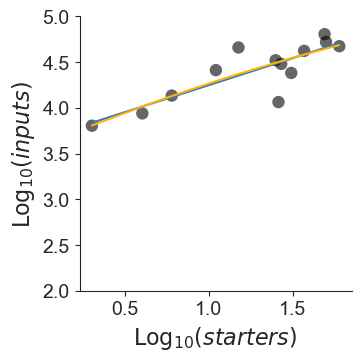

In [146]:
# Panel C1 : fit data in natural scale
plot_panel_c(df_log14, [result_log_lm14.best_fit, result_log_quad14.best_fit], 2, 5)
plt.savefig(os.path.join(figpath14, 'fig_s1_1c1.png'),  bbox_inches='tight')
plt.savefig(os.path.join(figpath14, 'fig_s1_1c1.eps'),  bbox_inches='tight', format = 'eps', dpi= 300)

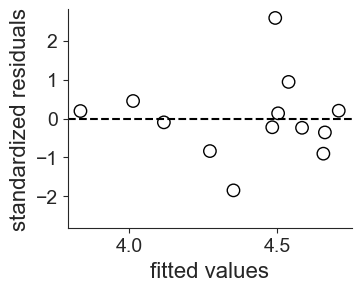

In [147]:
plot_panel_b(result_log_lm14)
plt.savefig(os.path.join(figpath14, 'fig_s1_1d1.png'),  bbox_inches='tight')
plt.savefig(os.path.join(figpath14, 'fig_s1_1d1.eps'),  bbox_inches='tight', format = 'eps', dpi= 300)